# OCR = Text detection + Text recognition
- Text detection
    - 단순히 Object detection 기법뿐 아니라 Segmentation 기법도 동원되며, 문자가 가지는 독특한 특성까지 고려한 형태로 지속적으로 발전
- Text recognition은
    - 검출된 영역의 문자가 무엇인지를 인식해 내는 과정
    - 문자 단위로 잘 분리된 텍스트 이미지만 담겨 있는 것이 아니므로, 이를 잘 인식하는 방식으로 발전

학습 목표
- Text Recognition 모델을 직접 구현할 수 있습니다.
- Text Recognition 모델 학습을 수행할 수 있습니다.
- Text Detection 모델과 연결하여 전체 OCR 시스템을 구현할 수 있습니다.

### OCR을 처음부터 끝까지 만들기에는 시간이 많이 소요되므로 Detection은 keras-ocr을 활용하고, Recognition은 직접 만들어 학습함

In [1]:
# 라이브러리
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = './data/'

TRAIN_DATA_PATH = HOME_DIR+'train/'
VALID_DATA_PATH = HOME_DIR+'valid/'
TEST_DATA_PATH = HOME_DIR+'test/'

print(TRAIN_DATA_PATH)

2024-07-09 09:29:54.855842: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 09:29:59.122845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


./data/train/


In [2]:
import pkg_resources

installed_packages = pkg_resources.working_set
installed_packages_list = sorted(["%s==%s" % (i.key, i.version) for i in installed_packages])
for package in installed_packages_list:
    print(package)


absl-py==2.1.0
asttokens==2.4.1
astunparse==1.6.3
certifi==2024.7.4
charset-normalizer==3.3.2
comm==0.2.2
debugpy==1.8.2
decorator==5.1.1
executing==2.0.1
flatbuffers==24.3.25
gast==0.6.0
google-pasta==0.2.0
grpcio==1.64.1
h5py==3.11.0
idna==3.7
ipykernel==6.29.5
ipython==8.26.0
jedi==0.19.1
jupyter-client==8.6.2
jupyter-core==5.7.2
keras==3.4.1
libclang==18.1.1
lmdb==1.5.1
markdown-it-py==3.0.0
markdown==3.6
markupsafe==2.1.5
matplotlib-inline==0.1.7
mdurl==0.1.2
ml-dtypes==0.3.2
namex==0.0.8
nest-asyncio==1.6.0
numpy==1.26.4
opt-einsum==3.3.0
optree==0.12.1
packaging==24.1
parso==0.8.4
pexpect==4.9.0
pillow==10.4.0
pip==24.1.2
platformdirs==4.2.2
prompt-toolkit==3.0.47
protobuf==4.25.3
psutil==6.0.0
ptyprocess==0.7.0
pure-eval==0.2.2
pygments==2.18.0
python-dateutil==2.9.0.post0
pyzmq==26.0.3
requests==2.32.3
rich==13.7.1
setuptools==59.6.0
six==1.16.0
stack-data==0.6.3
tensorboard-data-server==0.7.2
tensorboard==2.16.2
tensorflow-io-gcs-filesystem==0.37.1
tensorflow==2.16.1
termcolo

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


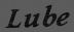

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


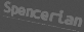

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


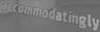

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


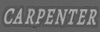

In [3]:
# 사용할 이미지 데이터셋은 lmdb 포맷(.mdb)으로 되어 있음 -> 데이터 확인하는 코드
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [4]:
# 모델 학습용 MJSynth데이터셋 클래스를 구현
# TensorFlow/Keras의 Sequence 클래스를 상속받아 데이터셋을 배치 단위로 불러오고 전처리하는 역할
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32), # (width, height)
                 max_text_len=22, # 필터링을 위한 최대 글자 수
                 is_train=False,
                 character='' 
                 ) :
        
        self.label_converter = label_converter  # 레이블을 인코딩/디코딩하는 변환기 설정
        self.batch_size = batch_size  # 배치 크기 설정
        self.img_size = img_size  # 이미지 크기 설정
        self.max_text_len = max_text_len  # 최대 텍스트 길이 설정
        self.character = character  # 사용할 문자 집합 설정
        self.is_train = is_train  # 학습 모드 여부 설정
        self.divide_length = 100  # 나눌 길이 설정

        # LMDB 데이터 열기
        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        # LMDB 데이터 접근 
        # 데이터 수 파악 (num-samples는 미리 LMDB에 저장해 둔 전체 데이터의 수)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    # divide_length를 사용함으로써, __len__ 메서드는 전체 배치를 divide_length로 나누어 보다 작은 덩어리로 분할
    # 메모리 사용량을 줄이기 위함
    def __len__(self):
        # 데이터셋의 길이 반환
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    # __getitem__에서 사용됨 
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            # 라벨 가져오기
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            
            # 이미지 가져오기
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            # 이미지 버퍼를 읽어서 이미지 객체로 변환
            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')  # 이미지를 RGB로 변환
            except IOError:
                img = Image.new('RGB', self.img_size)  # 이미지 읽기 실패 시 빈 이미지 생성
                label = '-'
            
            width, height = img.size  # 이미지의 가로, 세로 크기 가져오기
            
            target_width = min(int(width * self.img_size[1] / height), self.img_size[0])  # 목표 너비 계산
            target_img_size = (target_width, self.img_size[1])  # 목표 이미지 크기 설정
            img = np.array(img.resize(target_img_size)).transpose(1, 0, 2)  # 이미지를 목표 크기로 조정하고, 배열 형태로 변환
            
            # 라벨을 약간 더 다듬습니다
            label = label.upper()  # 라벨을 대문자로 변환
            out_of_char = f'[^{self.character}]'  # 사용할 문자 집합 설정
            label = re.sub(out_of_char, '', label)  # 사용할 문자 집합 외의 문자 제거
            label = label[:self.max_text_len]  # 최대 텍스트 길이로 자르기

        return (img, label)  # 이미지와 라벨 반환
    
    # __getitem__은 약속되어있는 메서드입니다
    #   __getitem__ 메서드는 Python에서 객체를 인덱싱할 때 호출됩니다. 
    #   MJDatasetSequence 클래스에서 __getitem__은 특정 인덱스에 해당하는 배치를 반환하는 역할을 합니다. 
    #   주로 Keras 모델의 fit 메서드를 호출할 때, 각 배치를 가져오기 위해 내부적으로 사용
    # 이 부분을 작성하면 slice할 수 있습니다
    # 사용 예시 
    ## 첫 번째 배치 가져오기
    ## inputs, outputs = dataset[0]
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    # 
    # Keras 모델의 fit 메서드를 호출할 때, Sequence 객체를 데이터 제너레이터로 사용합니다. 
    # 이때 Keras는 내부적으로 __len__ 메서드를 호출하여 에폭당 배치 수를 계산하고, 각 배치를 가져오기 위해 __getitem__ 메서드를 호출하면서 idx 값을 전달
    # idx = 배치의 순서임 
    def __getitem__(self, idx):
        # 1.idx에 해당하는 index_list만큼 데이터를 불러, todo 왜 idx 2개씩 작업하는지 이해가 안됨
        batch_indicies = self.index_list[
            idx * self.batch_size:
            (idx + 1) * self.batch_size
        ]
        
        # 빈 이미지와 라벨 배열 생성
        # *는 Python의 unpacking 연산자입니다. 이 연산자는 튜플이나 리스트의 요소를 개별 변수로 풀어주는 역할
        input_images = np.zeros([self.batch_size, *self.img_size, 3]) # (B, W, H, C)
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.image와 label을 불러오고 
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)  # 이미지와 라벨 가져오기
            encoded_label = self.label_converter.encode(label)  # 라벨 인코딩
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i, :width, :, :] = img  # 이미지를 입력 배열에 저장 
            labels[i, 0:len(encoded_label)] = encoded_label  # 인코딩된 라벨을 라벨 배열에 저장
            label_length[i] = len(encoded_label)  # 라벨 길이 저장
        
        # 3.사용하기 좋은 inputs과 outputs형태로 반환합니다
        inputs = {
            'input_image': input_images,  # 입력 이미지
            'label': labels,  # 인코딩된 라벨
            'input_length': input_length,  # 입력 길이
            'label_length': label_length,  # 라벨 길이
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}  # CTC 손실을 위한 출력

        return inputs, outputs  # 입력과 출력 반환

In [5]:
# Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있음
# 모델이 학습할 수 있는 형태로 변경
# 각 문자를 class로 생각하고, 
# 이를 step에 따른 class index로 변환해서 encode??

class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character # "-"(블랭크 문자)를 포함하여 문자 집합을 확장
         # 각 문자를 고유한 인덱스로 매핑하는 딕셔너리
         # self.label_map["A"] = 1, self.label_map["B"] = 2와 같은 방식, "-"는 0으로 매핑
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             # 연속된 같은 문자 사이에 블랭크 문자(인덱스 0)를 삽입하여 CTC 손실에서 같은 문자가 연속으로 나올 때 구분할 수 있도록 합니다.
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [6]:
# LabelConverter 테스트
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

The total number of characters is 36
Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [7]:
# CTC loss를 계산하기 위한 Lambda 함수
# 이 함수는 모델의 출력과 실제 라벨 간의 손실을 계산하여 모델이 더 정확하게 학습할 수 있도록 합니다.

# 입력 인자
#   labels: 실제 라벨입니다. 인코딩된 형태의 텍스트 라벨입니다.
#   y_pred: 모델의 출력 예측값입니다. Softmax를 거친 후의 확률 값들이 포함되어 있습니다.
#   label_length: 각 라벨의 길이입니다.
#   input_length: 모델의 입력 길이입니다. 보통 입력 시퀀스의 길이를 나타냅니다.
def ctc_lambda_func(args): 
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :] # todo 왜 2개를 잘라내는지 이해가 안됨 - CTC Loss를 계산할 때, 모델의 출력과 라벨의 길이가 달라도 사용할 수 있도록 blank를 포함하여 계산하더라도 1개만 잘라내면 되는데??
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length) # CTC loss 계산하는 함수 

In [8]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    # CTC 블랭크 토큰, ? 문자를 추가한 것을 고려, 위와 마찬가지로 2개 잘라내는 이유가 이해 안됨 . todo
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image') # (None, 100, 32, 3)
    
    # Build CRNN model
    # CNN부분 
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input) # (None, 100, 32, 64)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv) # (None, 50, 16, 64)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv) # (None, 50, 16, 128)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv) 
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv) # (None, 25, 2, 512)
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv) # (None, 24, 1, 512)
    # RNN부분
    sequnce = layers.Reshape(target_shape=(24, 512))(feature) # (None, 24, 512)
    sequnce = layers.Dense(64, activation='relu')(sequnce) # (None, 24, 64)  
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce) # (None, 24, 512) (양방향이므로 256*2)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce) # (None, 24, 512) (양방향이므로 256*2)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce) # (None, 24, num_chars)
    # CTC 손실 함수에 필요한 입력 생성 
    labels = layers.Input(shape=[22], dtype='int64', name='label') # (None, 22)
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length') # (None, 1)
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length') # (None, 1)
    # CTC 손실 계산
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    # 모델 정의 및 반환
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [9]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

2024-07-09 09:30:20.096532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 09:30:20.104154: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 09:30:20.104183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 09:30:20.105935: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 09:30:20.105957: I external/local_xla/xla/stream_executor

In [10]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
# ModelCheckPoint의 경우 'val_loss'를 모니터링하고 weight만 저장하는 옵션으로 지정해주세요.
# EarlyStopping도 'val_loss'를 모니터링해주세요.
# (EarlyStopping을 사용하지 않는 경우, model.fit()의 epoch 옵션을 20 정도로 설정해주세요.

checkpoint_path = 'model_checkpoint.keras'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'
)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False
)

model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=1,
          validation_data=val_set,
          validation_steps=len(val_set),
          # ModelCheckPoint와 EarlyStopping을 활용하는 경우 바로 아래 callbacks 옵션에 주석을 풀어주세요.
          callbacks=[ckp, earlystop]
)

ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data_2:0", shape=(None,), dtype=int64). Expected shape (None, 22), but input has incompatible shape (None,)[0m

Arguments received by Functional.call():
  • inputs={'input_image': 'tf.Tensor(shape=(None, 100, 32, 3), dtype=float64)', 'label': 'tf.Tensor(shape=(None, 22), dtype=int64)', 'input_length': 'tf.Tensor(shape=(None,), dtype=int64)', 'label_length': 'tf.Tensor(shape=(None,), dtype=int64)'}
  • training=True
  • mask={'input_image': 'None', 'label': 'None', 'input_length': 'None', 'label_length': 'None'}

In [ ]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = 'model_checkpoint.keras'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
Result: 	 SN9999999999999999999999


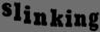

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Result: 	 999999999999999999999999


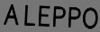

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Result: 	 999999999999999999999999


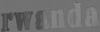

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Result: 	 S99999999999999999999999


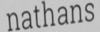

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Result: 	 999999999999999999999999


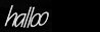

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Result: 	 999999999999999999999999


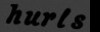

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Result: 	 MS9999999999999999999999


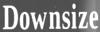

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Result: 	 999999999999999999999999


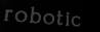

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Result: 	 S99999999999999999999999


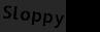

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Result: 	 P99999999999999999999999


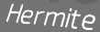

In [ ]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다 -> 어렵다고 하니 넘어가고, 프로젝트 후에 다시 보기
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)